In [2]:
from datetime import datetime
now = datetime.now;t0 = now()
print(now())

2022-01-27 08:58:15.029523


In [3]:
%time
import numpy as np
import pandas as pd
import ants
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


In [4]:
from importlib import reload
import pickle
import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models2;reload(make_models2);from make_models2 import *

In [5]:
%time 
# LOAD CVAE MODEL
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fn = '../tf_weights/CVAE_weights/CVAE_weights'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x155328133280> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x1553280e65e0>).


In [6]:
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')

patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

data = np.load('../Data/ABIDE-Anat-64iso-S982.npz')['data']
print(df.shape)
print(data.shape)

(982, 90)
(982, 64, 64, 64)


In [7]:
df.head()

,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3


In [9]:
def get_recon_and_twin(inMat):
    z = z_encoder.predict(inMat)[2]
    s = s_encoder.predict(inMat)[2]
    zeros = np.zeros(s.shape)

    recon = cvae_decoder.predict(np.hstack((z,s)))[:,:,:,:,0]
    twin = cvae_decoder.predict(np.hstack((z,zeros)))[:,:,:,:,0]

    return recon,twin

In [10]:
%%time
inMat = data[patients,:,:,:]
recon,twin = get_recon_and_twin(inMat)
print(inMat.shape)

(470, 64, 64, 64)
CPU times: user 2min 59s, sys: 31.2 s, total: 3min 30s
Wall time: 1min 11s


Text(0.5, 1.0, 'TD twin')

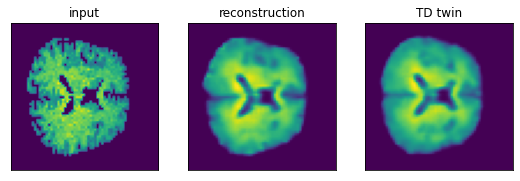

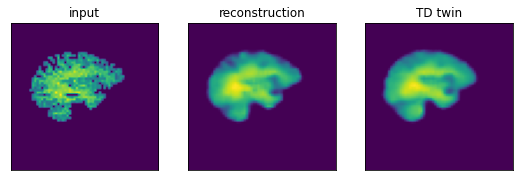

In [11]:
s = 0
plt.figure(figsize=(9,3));
plt.subplot(1,3,1);plt.imshow(inMat[s,:,:,40]);[ticks([]) for ticks in [plt.xticks,plt.yticks]];plt.title('input')
plt.subplot(1,3,2);plt.imshow(recon[s,:,:,40]);[ticks([]) for ticks in [plt.xticks,plt.yticks]];plt.title('reconstruction')
plt.subplot(1,3,3);plt.imshow(twin[s,:,:,40]);[ticks([]) for ticks in [plt.xticks,plt.yticks]];plt.title('TD twin')

s = 0
plt.figure(figsize=(9,3));
plt.subplot(1,3,1);plt.imshow(np.rot90(inMat[s,45,:,:]));[ticks([]) for ticks in [plt.xticks,plt.yticks]];plt.title('input')
plt.subplot(1,3,2);plt.imshow(np.rot90(recon[s,45,:,:]));[ticks([]) for ticks in [plt.xticks,plt.yticks]];plt.title('reconstruction')
plt.subplot(1,3,3);plt.imshow(np.rot90(twin[s,45,:,:]));[ticks([]) for ticks in [plt.xticks,plt.yticks]];plt.title('TD twin')

In [12]:
# Load template
template = ants.image_read('../Data/Atlas_brain_2mm.nii')
template_gm = ants.image_read('../Data/c1Atlas_brain_2mm.nii')
template_wm = ants.image_read('../Data/c2Atlas_brain_2mm.nii')
template_gw = template_gm+template_wm

interp_type = 4 # bSpline

template = template.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=interp_type)
template_gw = template_gw.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=interp_type)

template[template<.1] = 0
template_gw[template_gw<.1] = 0

#template_o = template.copy()
#template = ants.iMath_normalize(template)

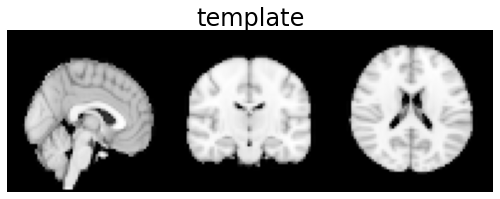

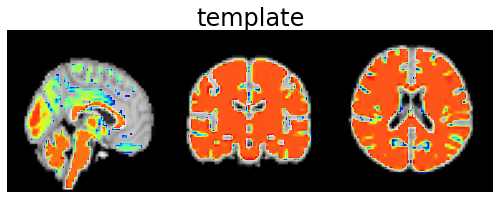

In [13]:
template.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title='template')
template.plot_ortho(template_gw,flat=True,xyz_lines=False,orient_labels=False,title='template')

In [14]:
def get_Js(invec,ofldr='jacobians'):
    from tqdm import tqdm
    home = os.getenv("HOME")
    tmp_dir = '/scratch/ants_files/'
    
    interpolator = 'bSpline'
    interp_type=4
    
    Js,normed_t1s,normed_recons,normed_twins,nativeJs = [],[],[],[],[]
    recon_brains,twin_brains,t1s=[],[],[]
    
    #recon,twin = get_corner_brains(invec)

    for i in tqdm(range(len(invec))):
        sub = df['BIDS_ID'].values[patients][invec[i]]
        
        #t1 = ants.image_read(os.path.join(home,'data','fMRI_InData','abide_bids',sub,'anat',f'{sub}_brain.nii'))
        t1 = ants.image_read(f'../../data/fMRI_InData/abide_bids/{sub}/anat/{sub}_brain.nii')
        #t1 = ants.image_read(f'../../data/fMRI_InData/abide_bids/{sub}/anat/{sub}_brain.nii')
        t1 = t1.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=interp_type)
        #t1 = ants.iMath_normalize(t1)
        
        
        recon_mat = recon[i,:,:,:]
        twin_mat = twin[i,:,:,:]
        
        recon_brain = t1.new_image_like(recon_mat)
        twin_brain = t1.new_image_like(twin_mat)
        
        twin_brain = ants.iMath_normalize(twin_brain)
        recon_brain = ants.iMath_normalize(recon_brain)
        
        # rigid match T1, Recon and Twin
        
        #twin_brain = ants.registration(fixed=t1,moving=twin_brain,type_of_transform='Rigid')['warpedmovout']
        #recon_brain = ants.registration(fixed=t1,moving=recon_brain,type_of_transform='Rigid')['warpedmovout']
        
        # Match twin to recon
        twin_brain = ants.registration(fixed=recon_brain,moving=twin_brain,type_of_transform='Rigid')['warpedmovout']        
        tx2t1 = ants.registration(fixed=t1,moving=recon_brain,type_of_transform='Rigid',outprefix=tmp_dir)
        # Match twin and recon to T1
        recon_brain = ants.apply_transforms(fixed=t1,moving=recon_brain,transformlist=tx2t1['fwdtransforms'],interpolator=interpolator) 
        twin_brain = ants.apply_transforms(fixed=t1,moving=twin_brain,transformlist=tx2t1['fwdtransforms'],interpolator=interpolator)
        
        # calculate jacobian in native space
        tx = ants.registration(fixed=recon_brain,moving=twin_brain,type_of_transform='SyN',outprefix=tmp_dir)
        J = ants.create_jacobian_determinant_image(domain_image=twin_brain,tx=tx['fwdtransforms'][0])
        J = J-1

        norm = ants.registration(fixed=template,moving=t1,type_of_transform='SyN',outprefix=tmp_dir)
        normed_t1 = ants.apply_transforms(fixed=template,moving=t1,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        
        normed_recon = ants.apply_transforms(fixed=template,moving=recon_brain,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        normed_twin = ants.apply_transforms(fixed=template,moving=twin_brain,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        normed_J = ants.apply_transforms(fixed=template,moving=J,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        
        # SAVE THE RESULTS
        
        # Where to save everything
        ofdir = os.path.join(home,ofldr)
        ofdir
        
        # MAKE OFDIR IF NOT EXIST
        _ = os.mkdir(ofdir) if not os.path.exists(ofdir) else 0
        
        # Make a dict
        res = dict()
        
        res['native_Js'] = J
        res['twin_brains'] = twin_brain
        res['recon_brains'] = recon_brain
        res['t1s'] = t1
        
        res['normed_Js'] = normed_J
        res['normed_t1s'] = normed_t1
        res['normed_recons'] = normed_recon
        res['normed_twins'] = normed_twin
        
        for key in list(res.keys()):            
            # make a subdir if needed
            _ = os.mkdir(os.path.join(ofdir,key)) if os.path.exists(os.path.join(ofdir,key))==False else 0 # One liner if statement
            res[key].to_filename(os.path.join(ofdir,key,f'{sub}_{key}.nii'))
    
    return res


In [15]:
run_extract = True

In [16]:
if run_extract:
    res = get_Js(np.arange(patients.sum()))

100%|██████████| 470/470 [53:06<00:00,  6.78s/it]  


In [18]:
## METRICS

In [19]:
home = os.getenv("HOME")
jac_dir = os.path.join(home,'jacobians')
folders = os.listdir(jac_dir)
folders

['native_Js',
 'twin_brains',
 't1s',
 'normed_Js',
 'recon_brains',
 'normed_recons',
 'normed_t1s',
 'normed_twins']

In [20]:
asd_subs = df_asd['BIDS_ID'].values

In [21]:
res = dict()
for folder in tqdm(folders):
    res[folder] = normed_Js = [ants.image_read(os.path.join(jac_dir,folder,f'{sub}_{folder}.nii')) for sub in asd_subs];

100%|██████████| 8/8 [00:24<00:00,  3.12s/it]


In [22]:
res_keys = list(res.keys())
res_keys

['native_Js',
 'twin_brains',
 't1s',
 'normed_Js',
 'recon_brains',
 'normed_recons',
 'normed_t1s',
 'normed_twins']

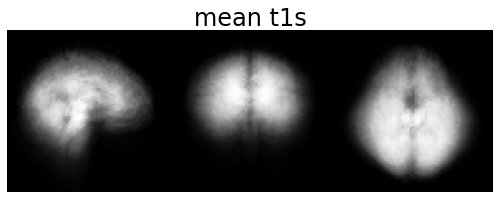

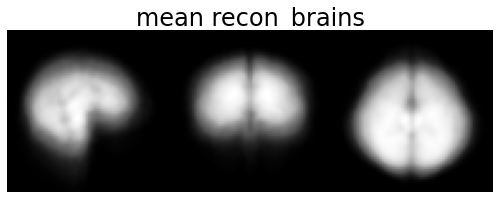

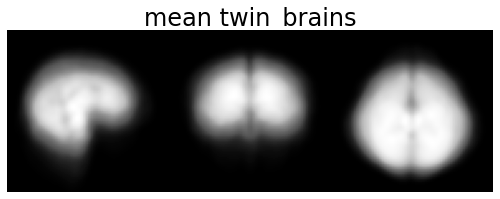

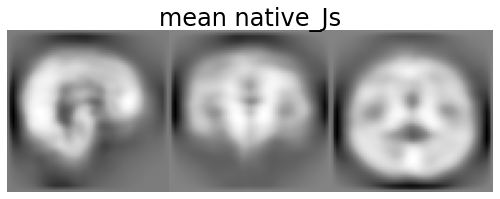

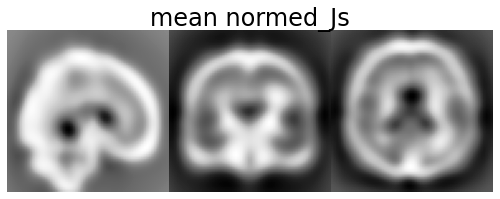

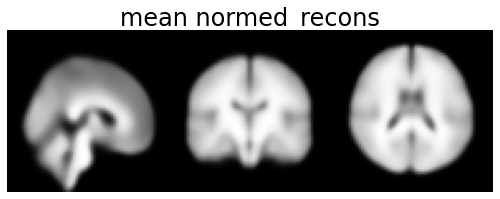

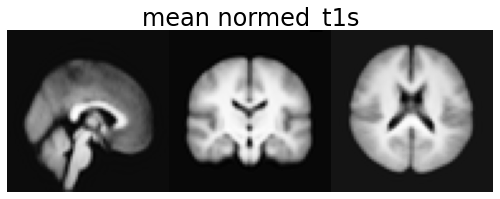

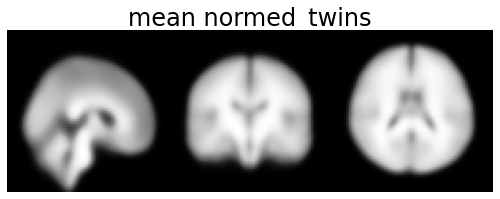

In [23]:
for key in ['t1s', 'recon_brains', 'twin_brains','native_Js','normed_Js', 'normed_recons', 'normed_t1s', 'normed_twins']:
    res[key][0].new_image_like(np.array([arr.numpy() for arr in res[key]]).mean(axis=0)).plot_ortho(title=f'mean {key}',flat=True,orient_labels=False,xyz_lines=False)

In [24]:
cmat_native_Js = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['native_Js']]))
cmat_twin_brains = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['twin_brains']]))
cmat_t1s = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['t1s']]))
cmat_recon_brains = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['recon_brains']]))

In [25]:
cmat_normed_Js = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['normed_Js']]))
cmat_normed_t1s = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['normed_t1s']]))
cmat_normed_recons = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['normed_recons']]))
cmat_normed_twins = np.corrcoef(np.array([arr.numpy().flatten() for arr in res['normed_twins']]))

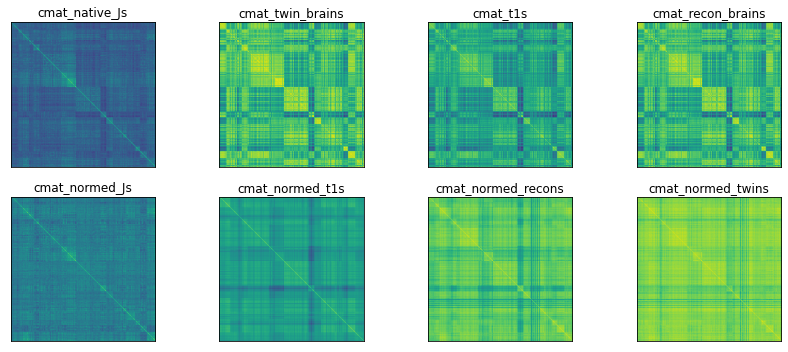

In [26]:
plt.subplots(2,4,figsize=(12,5))
mats = [cmat_native_Js,cmat_twin_brains,cmat_t1s,cmat_recon_brains,
        cmat_normed_Js,cmat_normed_t1s,cmat_normed_recons,cmat_normed_twins]

mat_ttls = ['cmat_native_Js','cmat_twin_brains','cmat_t1s','cmat_recon_brains','cmat_normed_Js','cmat_normed_t1s','cmat_normed_recons','cmat_normed_twins']

for idx,mat in enumerate(mats):
    plt.subplot(2,4,idx+1)
    plt.imshow(mat)
    [tics([]) for tics in [plt.xticks,plt.yticks]];
    plt.title(mat_ttls[idx])
    
plt.tight_layout()

In [27]:
keys = list(res.keys())
key = keys[0]

In [28]:
stat = dict()

In [29]:
for key in keys:
    m = np.array([arr.numpy() for arr in res[key]]).mean(axis=0).flatten()
    sim2mean = np.array([np.corrcoef(arr.numpy().flatten(),m)[0,1] for arr in res[key]])
    stat['sim2mean'+key] = sim2mean

In [30]:
list(stat.keys())

['sim2meannative_Js',
 'sim2meantwin_brains',
 'sim2meant1s',
 'sim2meannormed_Js',
 'sim2meanrecon_brains',
 'sim2meannormed_recons',
 'sim2meannormed_t1s',
 'sim2meannormed_twins']

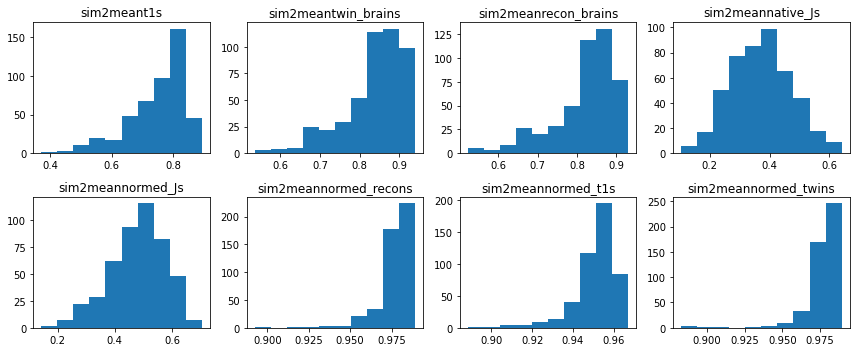

In [31]:
fig,axs = plt.subplots(2,4,figsize=(12,5))
keys  = [ 'sim2meant1s',
 'sim2meantwin_brains',
 'sim2meanrecon_brains',
    'sim2meannative_Js',
    'sim2meannormed_Js',
 'sim2meannormed_recons',
 'sim2meannormed_t1s',
 'sim2meannormed_twins']

for i,key in enumerate(keys):
    plt.subplot(2,4,i+1)
    plt.hist(stat[key])
    plt.title(key)
plt.tight_layout()

In [32]:
res_keys

['native_Js',
 'twin_brains',
 't1s',
 'normed_Js',
 'recon_brains',
 'normed_recons',
 'normed_t1s',
 'normed_twins']

In [33]:
nsubs = len(res['recon_brains'])

In [34]:
rec_twim_sim = np.array([np.corrcoef(res['recon_brains'][s].numpy().flatten(),res['twin_brains'][s].numpy().flatten())[0,1] for s in range(nsubs)])

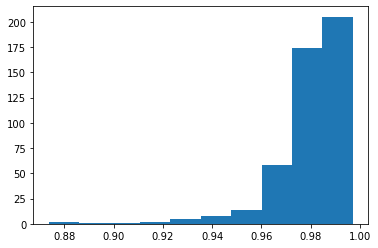

In [35]:
plt.hist(rec_twim_sim);

In [36]:
print(f'mean={rec_twim_sim.mean():.2f},sd={rec_twim_sim.std():.2f},min={rec_twim_sim.min():.2f},max={rec_twim_sim.max():.2f}')

mean=0.98,sd=0.02,min=0.87,max=1.00


before rigid| mean=0.97,sd=0.02,min=0.86,max=1.00


after rigid | mean=0.98,sd=0.02,min=0.87,max=1.00